In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import tensorflow as tf
import numpy as np
import pandas as pd
import torch
import math
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [122]:
data = '/content/drive/MyDrive/trajectories_imu/df_RGC.pkl'
with open(data, 'rb') as file:
    data = pickle.load(file)

label = '/content/drive/MyDrive/trajectories_imu/labels_RGC.pkl'
with open(label, 'rb') as file:
    labels = pickle.load(file)

labels = labels.values
umbral = 50

# Transformació per obtenir labels one-hot encoded
labels = np.array([[1, 0] if label < umbral else [0, 1] for label in labels])

# [1 0] = mostra positiva, [0 1] = mostra negativa
# classe 0 = mostra positiva, classe 1 = mostra negativa

In [123]:
data = np.reshape(data, (data.shape[0], data.shape[2], 3))
print(data.shape,len(labels))

(102, 1127, 3) 102


In [124]:
def build_model(lr=0.001, units_gru=64, units_gru_2=32, units_dense=16):
    model = tf.keras.Sequential()

    # Capa GRU 1 para procesar las secuencias temporales
    model.add(layers.GRU(units_gru, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))

    # Capa GRU 2 para capturar características a diferentes escalas
    model.add(layers.GRU(units_gru_2, return_sequences=False))

    # Capa totalmente conectada para procesar características a nivel de píxeles
    model.add(layers.Dense(units_dense, activation='relu'))  # Usamos ReLU en lugar de ReLU

    # Capa totalmente conectada final con función de activación sigmoide para clasificación binaria
    model.add(layers.Dense(2, activation='softmax'))  # Usamos softmax con 2 unidades para clasificación binaria

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

def create_dataloader(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    return dataset

(81, 2) (21, 2)


# HYPERPARAMETER TUNNING

In [126]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],
    'units_gru': [32, 64, 128],
    'units_gru_2': [16, 32, 64],
    'units_dense': [8, 16, 32]
}

# Usar KerasClassifier para clasificación binaria
keras_model = KerasClassifier(build_fn=build_model, verbose=0) # especificar el constructor del model + si volem imprimir el progres de l'entrenament

# cross-validation
grid_search = RandomizedSearchCV (keras_model, param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

<ipython-input-126-a042241440cb>:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasClassifier(build_fn=build_model, verbose=0) # especificar el constructor del model + si volem imprimir el progres de l'entrenament


In [127]:
#evaluacio del model amb els millor hyperparametres
best_model = grid_result.best_estimator_.model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print("\nLoss al conjunt de prova:", test_loss)
print("Accuracy al conjunt de prova:", test_acc)

1/1 [==============================] - 1s 1s/step - loss: 0.6292 - accuracy: 0.6667

Loss al conjunt de prova: 0.6291806101799011
Accuracy al conjunt de prova: 0.6666666865348816


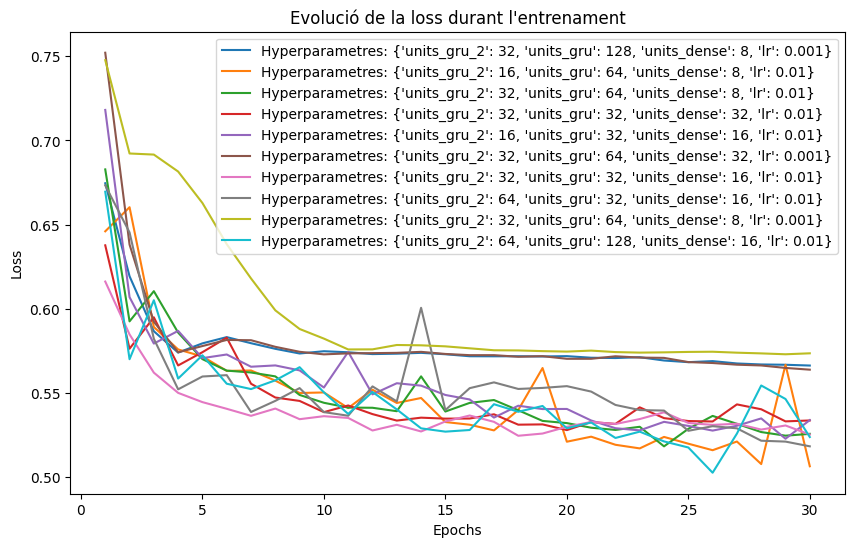

In [128]:
# Obtenir l'historial d'entrenament per a cada model en la cerca d'hyperparàmetres
loss_history = []
for params, cv_results in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
    model = build_model(**params)
    history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=0)
    loss_history.append(history.history['loss'])

plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history):
    plt.plot(range(1, len(loss)+1), loss, label=f"Hyperparametres: {grid_result.cv_results_['params'][i]}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

In [129]:
print("Millors hyperparàmetres:")
print(grid_result.best_params_)

print("\nMillor score:")
print(grid_result.best_score_)

Millors hyperparàmetres:
{'units_gru_2': 16, 'units_gru': 64, 'units_dense': 8, 'lr': 0.01}

Millor score:
0.7283950845400492


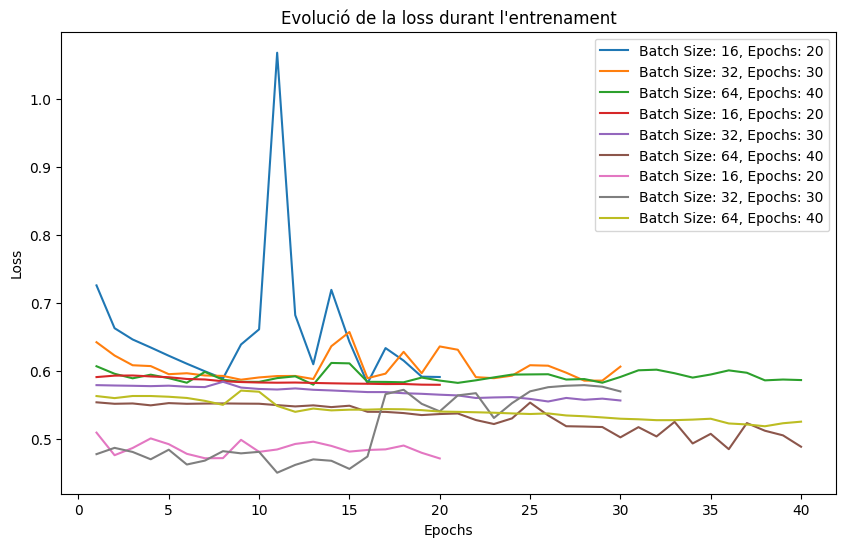

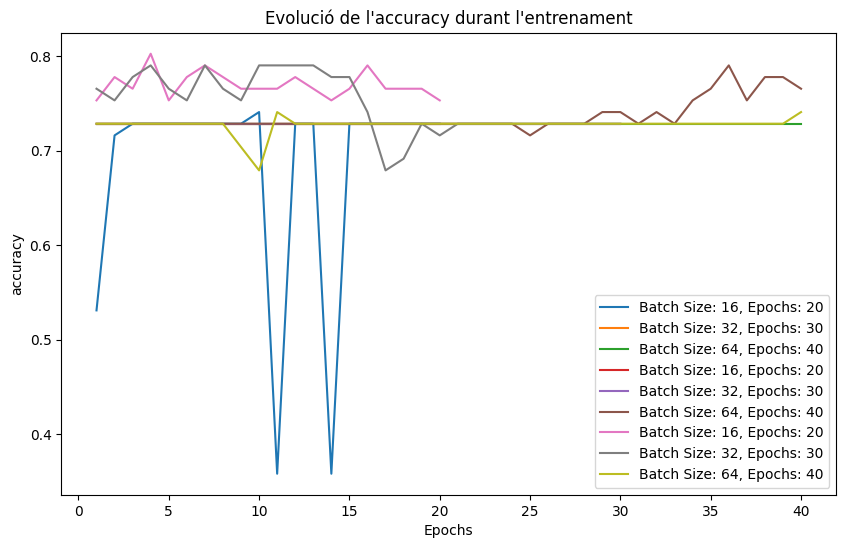

In [130]:
# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

#Diferents valors a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

loss_values = []
mae_values = []

for batch_size in batch_sizes:
    for epochs in epochs_values:
        train_dataset = create_dataloader(X_train, y_train, batch_size)
        history = model.fit(train_dataset, epochs=epochs, verbose=0)

        loss_values.append(history.history['loss'])
        mae_values.append(history.history['accuracy'])

#Graficar l'evolució de les proves (loss)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(loss_values[i])+1), loss_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

#Graficar l'evolució de les proves (f1)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(mae_values[i])+1), mae_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Evolució de l\'accuracy durant l\'entrenament')
plt.legend()
plt.show()


In [131]:
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

best_f1 = float('inf')
best_batch_size = None
best_epochs = None

# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']

# Cerca d'hyperparàmetres
for batch_size in batch_sizes:
    for epochs in epochs_values:
        model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1)

        _, test_f1 = model.evaluate(X_test, y_test, verbose=0)

        if test_f1 < best_f1:
            best_f1 = test_f1
            best_batch_size = batch_size
            best_epochs = epochs

print("Millor combinació d'hyperparàmetres:")
print("Batch size:", best_batch_size)
print("Epochs:", best_epochs)
print("accuracy al conjunt de prova:", best_f1)

Epoch 1/20
6/6 [==============================] - 15s 2s/step - loss: 0.6042 - accuracy: 0.6420
Epoch 2/20
6/6 [==============================] - 9s 1s/step - loss: 0.6154 - accuracy: 0.7284
Epoch 3/20
6/6 [==============================] - 9s 2s/step - loss: 0.6072 - accuracy: 0.7284
Epoch 4/20
6/6 [==============================] - 8s 1s/step - loss: 0.5698 - accuracy: 0.7284
Epoch 5/20
6/6 [==============================] - 9s 2s/step - loss: 0.5577 - accuracy: 0.7284
Epoch 6/20
6/6 [==============================] - 9s 1s/step - loss: 0.5869 - accuracy: 0.7284
Epoch 7/20
6/6 [==============================] - 9s 1s/step - loss: 0.5463 - accuracy: 0.7284
Epoch 8/20
6/6 [==============================] - 9s 2s/step - loss: 0.5980 - accuracy: 0.7284
Epoch 9/20
6/6 [==============================] - 8s 1s/step - loss: 0.5691 - accuracy: 0.7037
Epoch 10/20
6/6 [==============================] - 9s 2s/step - loss: 0.5546 - accuracy: 0.7284
Epoch 11/20
6/6 [==============================]

# Model final

In [132]:
#hyperparametres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
batch_size = best_batch_size

#creació i compilació model
final_model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

# Creació del DataLoader
train_dataset = create_dataloader(X_train, y_train, batch_size)

#entrenament del model amb els hyperparametres trobats
final_model.fit(train_dataset, epochs=best_epochs, verbose=1)

#Evaluació amb el conjunt test
test_dataset = create_dataloader(X_test, y_test, batch_size)
test_loss, test_f1 = final_model.evaluate(test_dataset, verbose=0)
print(f"Loss al conjunt de prova: {test_loss}")
print(f"Accuracy al conjunt de prova: {test_f1}")

Epoch 1/40
3/3 [==============================] - 10s 2s/step - loss: 0.6467 - accuracy: 0.6914
Epoch 2/40
3/3 [==============================] - 4s 1s/step - loss: 0.6267 - accuracy: 0.7284
Epoch 3/40
3/3 [==============================] - 6s 2s/step - loss: 0.5791 - accuracy: 0.7284
Epoch 4/40
3/3 [==============================] - 6s 2s/step - loss: 0.5714 - accuracy: 0.7284
Epoch 5/40
3/3 [==============================] - 4s 1s/step - loss: 0.5696 - accuracy: 0.7284
Epoch 6/40
3/3 [==============================] - 5s 1s/step - loss: 0.5667 - accuracy: 0.7284
Epoch 7/40
3/3 [==============================] - 5s 2s/step - loss: 0.5634 - accuracy: 0.7284
Epoch 8/40
3/3 [==============================] - 4s 1s/step - loss: 0.5629 - accuracy: 0.7284
Epoch 9/40
3/3 [==============================] - 6s 2s/step - loss: 0.5577 - accuracy: 0.7284
Epoch 10/40
3/3 [==============================] - 4s 1s/step - loss: 0.5597 - accuracy: 0.7284
Epoch 11/40
3/3 [==============================]

In [133]:
y_pred = final_model.predict(X_test)
for i in range(len(y_test)):
  print(y_test[i],"    ",y_pred[i])

1/1 [==============================] - 1s 1s/step
[1 0]      [0.5090283  0.49097168]
[0 1]      [0.22015855 0.7798415 ]
[0 1]      [0.3564938 0.6435062]
[0 1]      [0.15299673 0.8470033 ]
[0 1]      [0.19560651 0.8043935 ]
[0 1]      [0.62261873 0.37738135]
[1 0]      [0.24687321 0.7531268 ]
[0 1]      [0.3229162  0.67708385]
[0 1]      [0.48271674 0.51728326]
[1 0]      [0.37497878 0.6250212 ]
[0 1]      [0.52346313 0.47653687]
[1 0]      [0.5090283  0.49097168]
[0 1]      [0.3301303  0.66986966]
[0 1]      [0.18993375 0.8100663 ]
[0 1]      [0.31176403 0.68823594]
[0 1]      [0.26912564 0.73087436]
[0 1]      [0.1986346 0.8013654]
[1 0]      [0.19940539 0.8005946 ]
[1 0]      [0.00834518 0.99165475]
[1 0]      [0.16690885 0.83309114]
[0 1]      [0.3388494 0.6611505]


In [134]:
# Convertir les probabilitats en one-hot enoded vectors
preds_one_hot = np.argmax(y_pred, axis=1)
preds_one_hot_encoded = tf.keras.utils.to_categorical(preds_one_hot, num_classes=2)
y_test_one_hot = np.argmax(y_test, axis=1)

# Visualització resultats

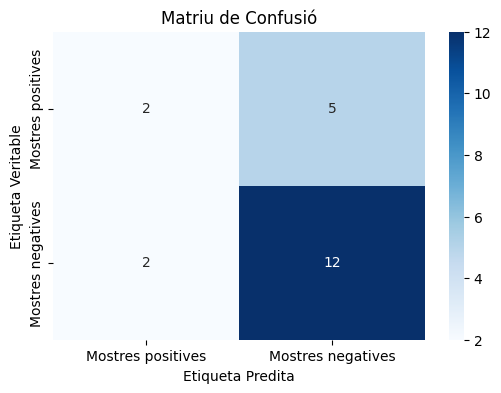

In [135]:
cm = confusion_matrix(y_test_one_hot, preds_one_hot)

clases = ['Mostres positives', 'Mostres negatives']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clases, yticklabels=clases)

plt.xlabel('Etiqueta Predita')
plt.ylabel('Etiqueta Veritable')
plt.title('Matriu de Confusió')
plt.show()

In [136]:
report = classification_report(y_test_one_hot, preds_one_hot)

print("Report de Classificació:")
print(report)

Report de Classificació:
              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.71      0.86      0.77        14

    accuracy                           0.67        21
   macro avg       0.60      0.57      0.57        21
weighted avg       0.64      0.67      0.64        21

